# Développement d'un algorithme en Spark

# Objectif du Notebook
Il s'agit de développer en Spark une méthode de gradient, dans le but de résoudre un problème de filtrage collaboratif, et de la comparer avec une méthode de la librairie MLIB. Ce Notebook a pour but le développement et la validation de l'approche, avant intégration et exploitation dans le cadre de l'infrastructure développée dans le projet. Pour information, de nombreuses versions de ce problème existent sur le web.

# Position du problème
Nous avons à notre disposition un RDD "ratings" du type (userID, movieID, rating). Les données sont fournies par le fichier `ratings.dat`, stockées  au format ci-joint :
```
UserID::MovieID::Rating::Timestamp
```

Ce RDD peut être stocké dans une matrice $R$ où l'on trouve "rating" à l'intersection de la ligne "userID" et de la colonne "movieID".
Si la matrice $R$ est de taille $m \times  n$, nous cherchons $P \in R^{m,k}$ et $Q \in R^{n,k}$ telles que $R \approx \hat{R} = PQ^T$.
Pour cela on considère le problème
$$ \min_{P,Q} \sum_{i,j : r_{ij} \text{existe}}  \ell_{i,j}(R,P,Q), $$
où
$$  \ell_{i,j}(R,P,Q)= \left(r_{ij} - q_{j}^{\top}p_{i}\right)^2 + \lambda(|| p_{i} ||^{2}_2 + || q_{j} ||^2_2 )  $$ et $(p_i)_{1\leq i\leq m}$ et $(q_j)_{1\leq j\leq n}$ sont les lignes des matrices $P$ et $Q$ respectivement. Le paramètre $\lambda\geq 0$ est un paramètre de régularisation.

Le problème que nous résolvons ici est un problème dit de "filtrage collaboratif", qui permet d'apporter une solution possible du  problème Netflix. Les données sont issues de la base de données  "The MoviLens Datasets" :

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19


In [4]:
# Librairies
import numpy as np
from scipy import sparse

# Environnement Spark 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

# A modifier/commenter selon votre configuration.
import os
#os.environ['PYSPARK_PYTHON'] = '/Users/abdelmahraye/anaconda3/bin/python'
os.environ['PYSPARK_PYTHON'] = '/home/ubuntu/.conda/envs/conda-env/bin/python'

conf = SparkConf()
conf.setMaster("local[*]")
conf.setAppName("Matrix Factorization")
sc = SparkContext(conf = conf)



#### Création du RDD et premières statistiques sur le jeu de données.

In [5]:
# Répertoire contenant le jeu de données
movieLensHomeDir="data/"

# ratings est un RDD du type (userID, movieID, rating)
def parseRating(line):
    fields = line.split('::')
    return int(fields[0]), int(fields[1]), float(fields[2])

ratingsRDD = sc.textFile(movieLensHomeDir + "ratings.dat").map(parseRating).setName("ratings").cache()

# Calcul du nombre de ratings
numRatings = ratingsRDD.count()
# Calcul du nombre d'utilisateurs distincts
numUsers = ratingsRDD.map(lambda r: r[0]).distinct().count()
# Calcul du nombre de films distincts
numMovies = ratingsRDD.map(lambda r: r[1]).distinct().count()
print("We have %d ratings from %d users on %d movies.\n" % (numRatings, numUsers, numMovies))

# Dimensions de la matrice R
M = ratingsRDD.map(lambda r: r[0]).max()
N = ratingsRDD.map(lambda r: r[1]).max()
matrixSparsity = float(numRatings)/float(M*N)
print("We have %d users, %d movies and the rating matrix has %f percent of non-zero value.\n" % (M, N, 100*matrixSparsity))

We have 1000209 ratings from 6040 users on 3706 movies.

We have 6040 users, 3952 movies and the rating matrix has 4.190221 percent of non-zero value.



Nous allons utiliser la routine ALS.train() de la librairie  [MLLib](http://spark.apache.org/docs/latest/ml-guide.html) et en évaluer la performance par un calcul de " Mean Squared Error" du  rating de prédiction.

__Question 1__

> Commenter les lignes de code suivantes en vous inspirant du code python http://spark.apache.org/docs/latest/mllib-collaborative-filtering.html#collaborative-filtering

On utilise la routine ALS.train() pour implémenter notre modèle de descente de gradientafin de prévoir les notes. Elle prend en argument certains paramètres (le rdd, le nombre d'itérations de la descente de gradient, le paramètre de régularisation, le nombre de caractéristiques du modèle (rang de la matrice)). C'est l'étape d'entrainement. 
Le modèle est ensuite évalué sur le jeu de données complet : on prédit les notes des films pour chaque utilisateurs ayant notés ces films. Ensuite on joint la prédiction aux notes du RDD initial. On calcule enfin un score (MSE) pour évaluer l'efficacité du modèle (écart entre les notes prédites et les notes effectives).


In [7]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
import numpy
# Construction du modèle de recommendations depuis l'approche "Alternating Least Squares"
rank = 10
numIterations = 10

# Paramètres de la méthode Alternating Least Squares (ALS)
# ratings – RDD de Rating ou tuple (userID, productID, rating).
# rank – Rang de la matrice modèle.
# iterations – Nombre d'itérations. (default: 5)
# lambda_ – Paramètre de régularisation. (default: 0.01)
model = ALS.train(ratingsRDD, rank, iterations=numIterations, lambda_=0.02)

# Evaluation du modèle sur le jeu de données complet
testdata = ratingsRDD.map(lambda p: (p[0], p[1]))
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = ratingsRDD.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error = " + str(MSE))

Mean Squared Error = 0.5836596555987201


#  Algorithmes de descente de gradient

Le but de cette section est  
1. de calculer le gradient de la fonction,
2. d'implémenter une méthode de gradient,
3. de mesurer la précision de cette méthode

__Question 2__

> Séparer le jeu de données en un jeu d'apprentissage (70%) et un jeu de test, en utilisant la fonction randomsplit ( http://spark.apache.org/docs/2.0.0/api/python/pyspark.html )

> Compléter la routine ci-dessous qui retourne le "rating" prédit. Créer un RDD contenant `(i,j,true rating,predicted rating)`. 

> Compléter la routine qui calcule le Mean Square Error (MSE) sur le jeu de données.

> Tester ensuite la routine de MSE en vous donnant les matrices $P$ et $Q$ aléatoires (utiliser np.random.rand(M,K)) et calculer quelques "ratings" prédits. 



In [8]:
# Séparation du jeu de données en un jeu d'apprentissage et un jeu de test
# Taille du jeu d'apprentissage (en %) 
learningWeight = 0.7
# Création des RDD "apprentissage" et "test" depuis la fonction randomsplit
trainRDD, testRDD = ratingsRDD.randomSplit([learningWeight, 1-learningWeight], 10)
testRatings = testRDD.count()
alpha = 0.1
lamb = 0.05

# Calcul du rating prédit
def predictedRating(x, P, Q):
    """ 
    This function computes predicted rating
    Args:
        x: tuple (UserID, MovieID, Rating)
        P: user's features matrix (M by K)
        Q: item's features matrix (N by K)
    Returns:
        predicted rating:  
    """  
    i = x[0]-1
    j = x[1]-1
    r = x[2]
    rate = np.dot(P[i,:],Q[j,:])
    return x[0], x[1],rate 
    
# Calcul de l'erreur MSE 
def computeMSE(rdd, P, Q):
    """ 
    This function computes Mean Square Error (MSE)
    Args:
        rdd: RDD(UserID, MovieID, Rating)
    Returns:
        mse: mean square error 
    """ 
    predictions = rdd.map(lambda x : predictedRating((x[0], x[1], x[2]), P, Q)).map(lambda r : ((r[0], r[1]), r[2]))
    ratesAndPreds = rdd.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)

    return ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()

In [9]:
# Tailles des jeux de données d'apprentissage et de tests.
print("Size of the training dataset:", trainRDD.count())
print("Size of the testing dataset:", testRDD.count())

# Création de matrices aléatoires de dimension (M,K) et (N,K)
K = 20 
P = np.random.rand(M,K)
Q = np.random.rand(N,K)

predictions = testRDD.map(lambda x : predictedRating((x[0], x[1], x[2]), P, Q)).map(lambda r : ((r[0], r[1]), r[2]))
ratesAndPreds = testRDD.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)

# Calcul et affichage de l'erreur MSE pour ces matrices aléatoires
MSE = computeMSE(testRDD, P, Q)
print("Mean Squared Error = " + str(MSE))

# Affichage de quelques ratings prédits depuis ces matrices
for i in np.linspace(0, testRatings-1, 8).astype(int):
    predict = predictions.collect()[i]
    print("User ID : {}\tMovie ID : {}\t\tPredicted rating : {}".format(predict[0][0], predict[0][1], predict[1]))


Size of the training dataset: 700091
Size of the testing dataset: 300118
Mean Squared Error = 4.201224600357969
User ID : 1	Movie ID : 3408		Predicted rating : 6.468988222330816
User ID : 924	Movie ID : 899		Predicted rating : 5.779861213269656
User ID : 1702	Movie ID : 2355		Predicted rating : 3.865467912803582
User ID : 2613	Movie ID : 2599		Predicted rating : 4.14544743447412
User ID : 3507	Movie ID : 839		Predicted rating : 3.4672254266704456
User ID : 4279	Movie ID : 3264		Predicted rating : 4.645952125051033
User ID : 5153	Movie ID : 3035		Predicted rating : 7.30117816411887
User ID : 6040	Movie ID : 562		Predicted rating : 5.529937772944751


__Question 3__

> Donner la formule des dérivées des fonctions $\ell_{i,j}$ selon $p_t$ et $q_s$ avec $1\leq t\leq m$ et $1\leq s\leq n$.

Dérivée par rapport à $p_t$ : $$  \ell_{i,j}'(R,P,Q)=  -2q_{j} *\left(r_{ij} - q_{j}^{\top}p_{i}\right) + 2\lambda(|| p_{i} ||  $$ 


Dérivée par rapport à $q_s$ : $$  \ell_{i,j}'(R,P,Q)=  -2p_{i} *\left(r_{ij} - q_{j}^{\top}p_{i}\right) + 2\lambda(||  q_{j}||  $$ 

> Commenter et compléter l'implantation de l'algorithme de gradient sur l'ensemble d'apprentissage. Prendre un pas égal à $\gamma=0.001$ et arrêter sur un nombre maximum d'itérations. 

> Commenter les tracés de convergence et des indicateurs de qualité de la prévision en fonction de la dimension latente (rang de $P$ et $Q$).

In [10]:
# Algorithem de descente de gradient pour la factorisation de matrices
def GD(trainRDD, K=10, MAXITER=50, GAMMA=0.001, LAMBDA=0.05):
    # Construction de la matrice R (creuse)
    row=[]
    col=[]
    data=[]
    for part in trainRDD.collect():
        row.append(part[0]-1)
        col.append(part[1]-1)
        data.append(part[2])
    R=sparse.csr_matrix((data, (row, col)))
    
    # Initialisation aléatoire des matrices P et Q
    M,N = R.shape
    P = np.random.rand(M,K)
    Q = np.random.rand(N,K)
    
    # Calcul de l'erreur MSE initiale
    mse=[]
    mse_tmp = computeMSE(trainRDD, P, Q)
    mse.append([0, mse_tmp])
    
    # Boucle
    nonzero = R.nonzero()
    nbNonZero = R.nonzero()[0].size
    rows, cols = R.shape
    I,J = nonzero[0], nonzero[1]
    for epoch in range(MAXITER):
        
        for i,j in zip(I,J):
            # Mise à jour de P[i,:] et Q[j,:] par descente de gradient à pas fixe
            Iij= R[i,j] - np.vdot(P[i,:],Q[j,:])
       
            P[i,:] = P[i,:] - GAMMA*(2*LAMBDA*P[i,:] -2*Iij*Q[j,:])
            Q[j,:] = Q[j,:] - GAMMA*(2*LAMBDA*Q[j,:] -2*Iij*P[i,:])
        # Calcul de l'erreur MSE courante, et sauvegarde dans le tableau mse 
        mseEp=computeMSE(trainRDD, P, Q)
        mse.append([epoch,mseEp])
        #affichage du nouveau MSE courant
        print("epoch: ", str(epoch), " - MSE: ", str(mseEp))
    return P, Q, mse


In [11]:
# Calcul de P, Q et de la mse
P,Q,mse = GD(trainRDD, K=10, MAXITER=10, GAMMA=0.001, LAMBDA=0.05)

epoch:  0  - MSE:  1.0350549352841527
epoch:  1  - MSE:  0.9016493513791374
epoch:  2  - MSE:  0.8647696448885194
epoch:  3  - MSE:  0.8463434181754048
epoch:  4  - MSE:  0.8352621410481273
epoch:  5  - MSE:  0.8278926971815715
epoch:  6  - MSE:  0.8226508510298025
epoch:  7  - MSE:  0.818729539839099
epoch:  8  - MSE:  0.8156744072737663
epoch:  9  - MSE:  0.8132107151377985


[[0, 2.9176174008967655], [0, 1.0350549352841527], [1, 0.9016493513791374], [2, 0.8647696448885194], [3, 0.8463434181754048], [4, 0.8352621410481273], [5, 0.8278926971815715], [6, 0.8226508510298025], [7, 0.818729539839099], [8, 0.8156744072737663], [9, 0.8132107151377985]]


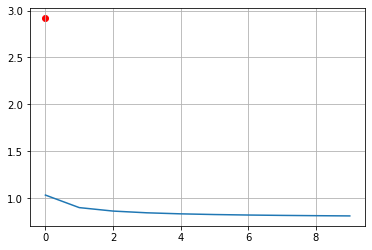

In [19]:
import matplotlib.pyplot as plt 
print(mse)
# Affichage de l'erreur MSE avec P et Q aléatoires
plt.scatter(mse[0][0], mse[0][1], color='r')
# Affichage de l'erreur MSE après chaque iteration
plt.plot([x[0] for x in mse[1:]], [x[1] for x in mse[1:]])
plt.grid()
plt.show()

On observe une décroissance du MSE au fur et à mesure que le nombre d'itérations augmente. Cette décroissance se réduit au fur et à mesure des itérations. Le MSE pour P et Q aléatoires (point rouge sur la figure) est bien plus important que pour P et Q calculés suite à une itération de la descente de gradient (2.91 contre 1.035).
Nous pouvons observation une stagnation (à 0,81) à partir de la 6ème itération, montrant l'atteinte et la convergence d'un minimum global/local de notre fonction convexe à minimiser.

__Question 4__

> Calculer les ratings prédits par la solution de la méthode du gradient dans un RDD

> Comparer sur le jeu de test les valeurs prédites aux ratings sur 5 échantillons aléatoires.

In [31]:
# Calcul et affichage des ratings prédits
predictions = testRDD.map(lambda x : predictedRating((x[0], x[1], x[2]), P, Q)).map(lambda r : ((r[0], r[1]), r[2]))
ratesAndPreds = testRDD.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)

# Affichage de quelques ratings prédits depuis ces matrices
for i in np.linspace(0, testRatings-1, 5).astype(int):
    ratesAndPredsTmp = ratesAndPreds.collect()[i]
    print("User ID : {}\tMovie ID : {}\t\tPredicted rating : {:.6f}\t\tReal rating : {:.6f}".format(ratesAndPredsTmp[0][0], ratesAndPredsTmp[0][1], ratesAndPredsTmp[1][1], ratesAndPredsTmp[1][0]))


User ID : 1	Movie ID : 1		Predicted rating : 4.253515		Real rating : 5.000000
User ID : 15	Movie ID : 788		Predicted rating : 2.729967		Real rating : 3.000000
User ID : 10	Movie ID : 1042		Predicted rating : 3.849144		Real rating : 5.000000
User ID : 2	Movie ID : 1213		Predicted rating : 4.060701		Real rating : 2.000000
User ID : 6040	Movie ID : 1079		Predicted rating : 3.764212		Real rating : 2.000000
